In [7]:
import os
import torch
import numpy as np
from torch import nn

from deep_fields import data_path
from deep_fields.models.crypto.predictors import CryptoSeq2Seq
from deep_fields.data.crypto.dataloaders import CryptoDataLoader
from deep_fields.models.crypto.predictors import CryptoSeq2NeuralSDE

from pprint import pprint

from matplotlib import pyplot as plt

%matplotlib inline 

In [8]:
date_string = "2021-06-14"
crypto_folder = os.path.join(data_path, "raw", "crypto")
data_folder = os.path.join(crypto_folder, date_string)

kwargs = {"path_to_data":data_folder,
          "batch_size": 29,
          "steps_ahead":10,
          "date_string": date_string,
          "clean":"interpol",
          "span":"full"}

data_loader = CryptoDataLoader('cpu', **kwargs)
data_batch = next(data_loader.train.__iter__())
test_data_batch = next(data_loader.test.__iter__())

In [9]:
model_param = CryptoSeq2Seq.get_parameters()
inference_param = CryptoSeq2Seq.get_inference_parameters()

In [10]:
model_dir="C:/Users/cesar/Desktop/Projects/General/deep_random_fields/results/crypto_seq2seq/1637576663/"

In [11]:
cs2s = CryptoSeq2Seq(model_dir=model_dir)

Loading Model No Inference


In [23]:
id_to_check = 20
series_index = 0
use_case="prediction"
#use_case="train"

output, unfolded_series = cs2s(test_data_batch,use_case=use_case)
if use_case == "train":
    real_series = unfolded_series[id_to_check,:,0,series_index]
else:
    real_series = unfolded_series[id_to_check,:,series_index]

In [24]:
step_to_check = 1
series_index_map = {"price":0,"market":1,"volume":2}
series_check = "price"
series_index = series_index_map[series_check]

prediction_0 = output[id_to_check,:,0,series_index].detach().numpy()
prediction_1 = output[id_to_check,:,1,series_index].detach().numpy()
prediction_2 = output[id_to_check,:,2,series_index].detach().numpy()
prediction_3 = output[id_to_check,:,3,series_index].detach().numpy()
prediction_4 = output[id_to_check,:,4,series_index].detach().numpy()
prediction_5 = output[id_to_check,:,5,series_index].detach().numpy()

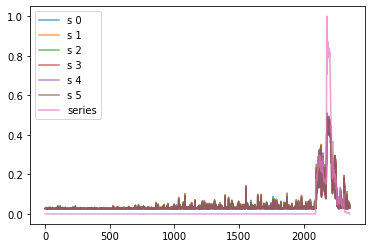

In [25]:
plt.plot(prediction_0,label="s 0 ",alpha=0.7)
plt.plot(prediction_1,label="s 1",alpha=0.7)
plt.plot(prediction_2,label="s 2",alpha=0.7)
plt.plot(prediction_3,label="s 3",alpha=0.7)
plt.plot(prediction_4,label="s 4",alpha=0.7)
plt.plot(prediction_5,label="s 5",alpha=0.7)

plt.plot(real_series,label="series",alpha=0.7)
plt.legend(loc="best")

In [48]:
mu_ml, sigma_square_ml = ml_estimates_black_scholes_from_predictors(output)

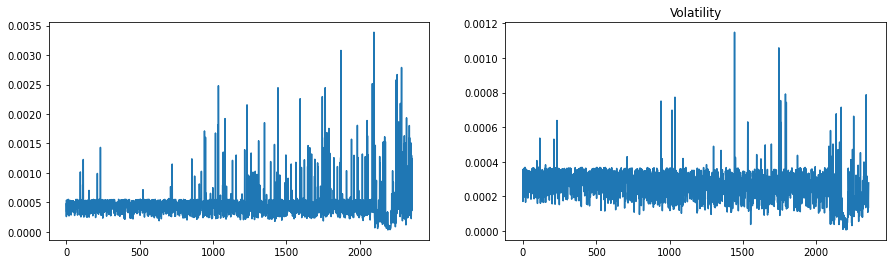

In [49]:
fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(15,4))
ax[1].set_title("Rate Returns")
ax[0].plot(mu_ml[id_to_check].detach().numpy())
ax[1].set_title("Volatility")
ax[1].plot(sigma_square_ml[id_to_check].detach().numpy())

# Estimate Black Scholes from Prediction

In [ ]:
def ml_estimates_of_geometric_brownian_motion_prediction(data_loader,skip_end=10):
    # we remove last 4 days in order to compensate for errors in the gathering of the data
    # (many points are missing at the end due to download speed)
    portfolio_survival = data_loader.portfolio_survival - skip_end
    prices = data_loader.portfolio_pmv[:,:,0]
    X = torch.log(prices)

    log_initial_prices = torch.log(data_loader.portfolio_initial_prices)
    log_final_prices = torch.log(data_loader.portfolio_final_prices)

    dX = log_final_prices - log_initial_prices
    DX = X[:,1:] - X[:,:-1]
    DX = DX**2.
    DX[DX != DX] = 0.
    DX[DX == np.inf] = 0.
    DX[DX == -np.inf] = 0.

    sigma_square_ml = DX.sum(axis=1)/portfolio_survival - (dX**2)/portfolio_survival**2
    mu_ml = DX.sum(axis=1)/portfolio_survival + 0.5*sigma_square_ml

    return DX,sigma_square_ml,mu_ml